#Modeling

In this part, we verify if the derived features hold any value by running the RandomForest classifier on the dataset and obtain the feature importances of all the features in the dataset.

3 different modelling strategies are performed - Random Model, Logistic Classification and Light GBM.

##Install Libraries

In [1]:
pip install dask[dataframe]

     |████████████████████████████████| 118 kB 4.8 MB/s 


In [2]:
pip install biosppy

     |████████████████████████████████| 85 kB 2.4 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=91d0e0377266f0ce509a241ad2581f9559c54d1b00a9be5cd357f3861a6606da
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [3]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
#Use the Biosppy module to derive features from the denoised data
from biosppy.signals import ecg, resp,eeg
from scipy.interpolate import interp1d
#Use Dask to work with the huge dataset. 
import dask
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings. filterwarnings("ignore") 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category',ordered=True,)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


##Read the pre-processed training dataset. 

This dataset contains the original features and the derived features.



In [6]:
#Use dask to read the data
train_df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/pre-processed_train1.csv')
train_df = train_df.compute()

In [7]:
#Reduce memory usage of the training dataset.
train_data = reduce_mem_usage(train_df)

Memory usage of dataframe is 3453.60 MB
Memory usage after optimization is: 895.89 MB
Decreased by 74.1%


In [ ]:
print(train_data.shape)

(4867421, 92)


In [ ]:
train_data.columns

Index(['crew', 'time', 'seat', 'gsr', 'denoised_r', 'denoised_ecg', 'r_rate',
       'heart_rate', 'fp1_f7', 'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3',
       'c3_p3', 'p3_o1', 'fz_cz', 'cz_pz', 'pz_poz', 'fp2_f8', 'f8_t4',
       't4_t6', 't6_o2', 'fp2_f4', 'f4_c4', 'c4_p4', 'p4_o2', 'egg_theta0',
       'egg_theta1', 'egg_theta2', 'egg_theta3', 'egg_theta4', 'egg_theta5',
       'egg_theta6', 'egg_theta7', 'egg_theta8', 'egg_theta9', 'egg_theta10',
       'egg_theta11', 'egg_theta12', 'egg_theta13', 'egg_theta14',
       'egg_theta15', 'egg_theta16', 'egg_theta17', 'egg_theta18',
       'egg_theta19', 'egg_alpha_low0', 'egg_alpha_low1', 'egg_alpha_low2',
       'egg_alpha_low3', 'egg_alpha_low4', 'egg_alpha_low5', 'egg_alpha_low6',
       'egg_alpha_low7', 'egg_alpha_low8', 'egg_alpha_low9', 'egg_alpha_low10',
       'egg_alpha_low11', 'egg_alpha_low12', 'egg_alpha_low13',
       'egg_alpha_low14', 'egg_alpha_low15', 'egg_alpha_low16',
       'egg_alpha_low17', 'egg_alpha_low18', 

In [9]:

train_data.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)

In [10]:
y = train_data['target']
train_data.drop(['target'],inplace=True,axis=1)

##Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_cv,y_train,y_cv=train_test_split(train_data,y,stratify=y,test_size=0.3,random_state=1)

In [ ]:
X_train.shape

(3407194, 89)

In [ ]:
X_cv.shape

(1460227, 89)

##Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(verbose=1,n_jobs=-1)
clf.fit(X_train,y_train)

print(clf.feature_importances_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 52.4min finished


[0.04615734 0.04794708 0.00894566 0.09159662 0.0835853  0.12560577
 0.02574663 0.04182043 0.00536941 0.00417697 0.00395714 0.00308899
 0.00503305 0.00620793 0.00286132 0.00291549 0.00557844 0.00512554
 0.00608318 0.00595782 0.00367165 0.0029063  0.00301381 0.0051373
 0.00462658 0.00281782 0.00279115 0.00414106 0.00403492 0.00436931
 0.00518417 0.004793   0.00385997 0.00436764 0.00450651 0.00420111
 0.00391724 0.0058165  0.00351524 0.00474021 0.00356922 0.00397662
 0.00349559 0.00406807 0.00374322 0.00555701 0.00397975 0.00337295
 0.00308283 0.00329923 0.00346343 0.00297023 0.00339161 0.00370146
 0.00358789 0.00299303 0.00304012 0.00343466 0.00336077 0.00329439
 0.00326297 0.00303595 0.00298776 0.00307597 0.00315234 0.00352904
 0.00288037 0.00345809 0.00311015 0.00362531 0.00354533 0.00312884
 0.00361126 0.00402329 0.00366446 0.00302778 0.00277104 0.00364726
 0.00331834 0.00361612 0.00335779 0.00371841 0.00310406 0.00323331
 0.00298454 0.00395351 0.00334771 0.16027576 0.06799959]


<BarContainer object of 89 artists>

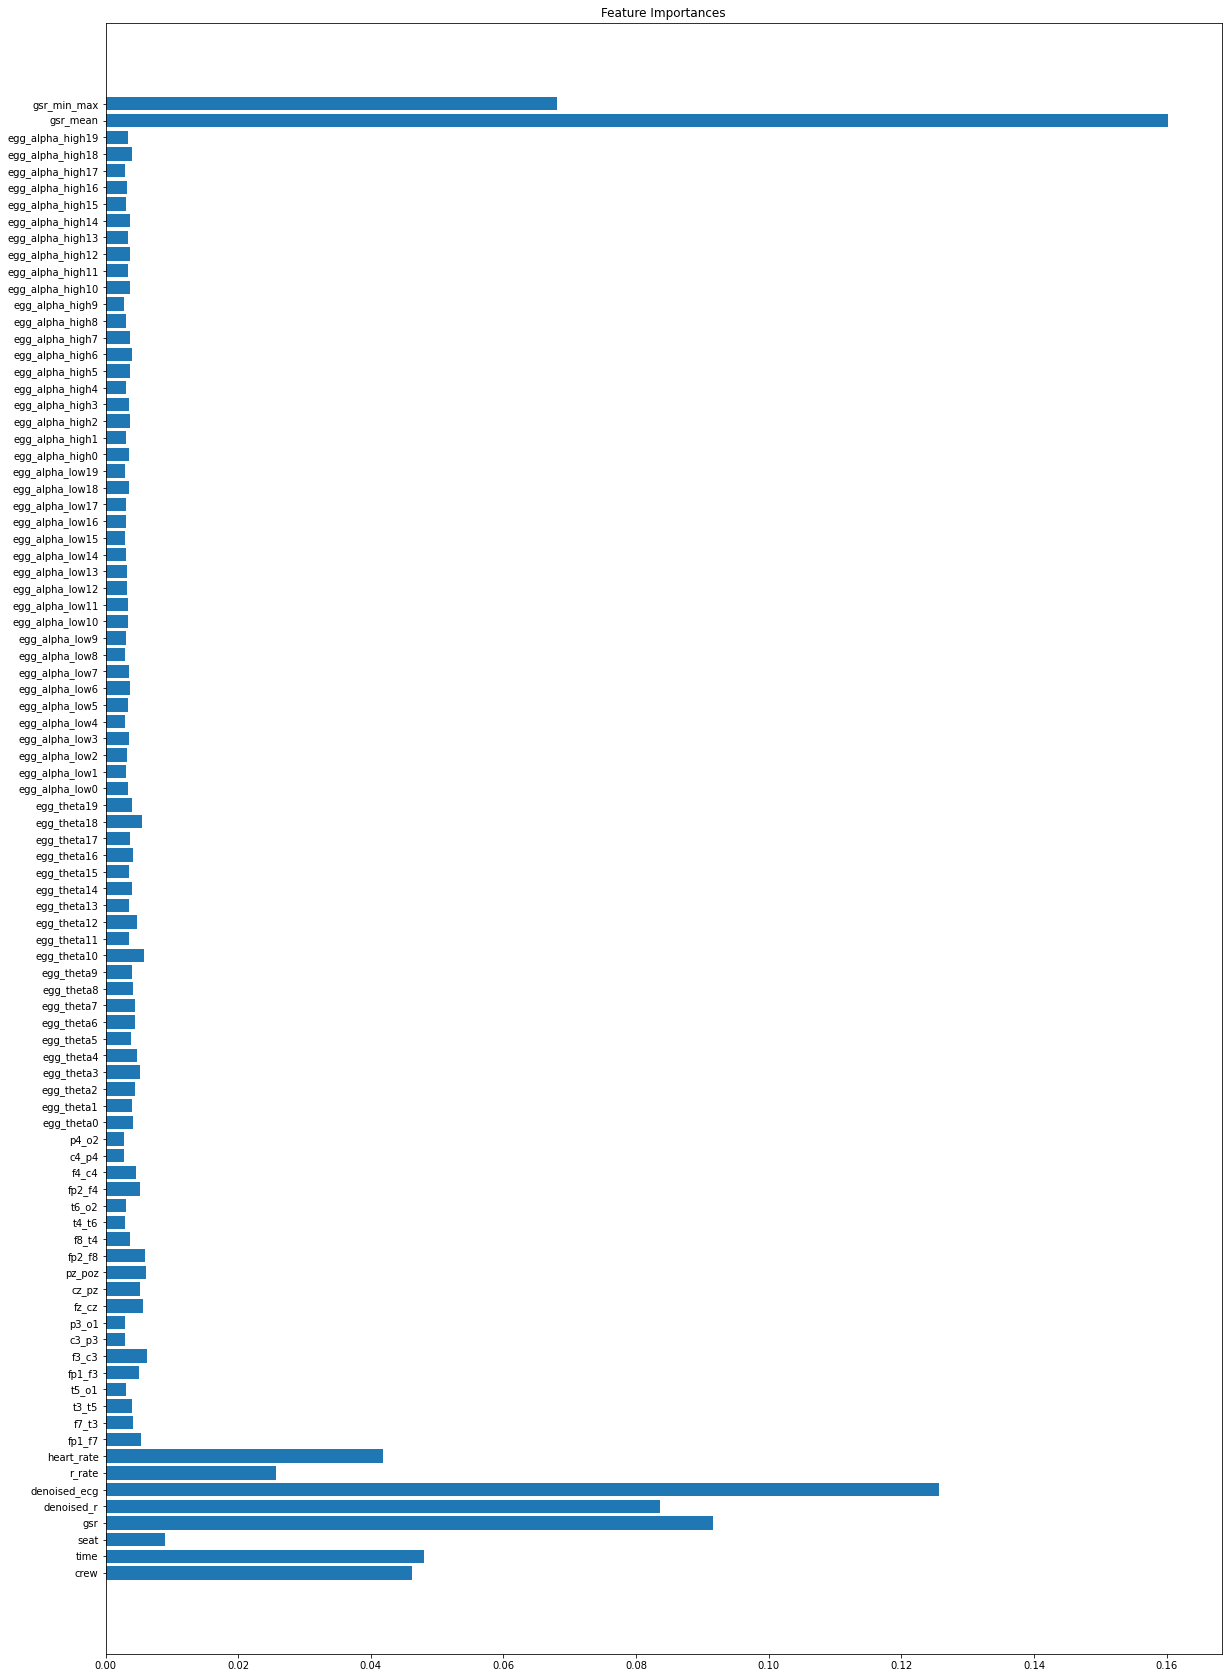

In [ ]:
plt.figure(figsize=(20,30))
plt.title('Feature Importances')
plt.barh(X_train.columns,clf.feature_importances_)

In [ ]:

imp_features = pd.Series(clf.feature_importances_, index=train_data.columns)
print(imp_features.nlargest(50).keys())

Index(['gsr_mean', 'denoised_ecg', 'gsr', 'denoised_r', 'gsr_min_max', 'time',
       'crew', 'heart_rate', 'r_rate', 'seat', 'f3_c3', 'pz_poz', 'fp2_f8',
       'egg_theta10', 'fz_cz', 'egg_theta18', 'fp1_f7', 'egg_theta3', 'fp2_f4',
       'cz_pz', 'fp1_f3', 'egg_theta4', 'egg_theta12', 'f4_c4', 'egg_theta7',
       'egg_theta2', 'egg_theta6', 'egg_theta8', 'f7_t3', 'egg_theta0',
       'egg_theta16', 'egg_theta1', 'egg_alpha_high6', 'egg_theta19',
       'egg_theta14', 't3_t5', 'egg_alpha_high18', 'egg_theta9', 'egg_theta5',
       'egg_theta17', 'egg_alpha_high14', 'egg_alpha_low6', 'f8_t4',
       'egg_alpha_high7', 'egg_alpha_high10', 'egg_alpha_high2',
       'egg_alpha_high12', 'egg_alpha_high5', 'egg_alpha_low7', 'egg_theta13'],
      dtype='object')


Most of the derived features have made it to the top 10 most important features as determined by the Random Forest classifier.

#Models

##Random Model

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

y_train_len = y_train.shape[0]
y_cv_len = y_cv.shape[0]
print(y_train_len)

tr_predicted_y = np.zeros((y_train_len,4))

for i in range(y_train_len):
  rand_probs = np.random.rand(1,4)
  tr_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))

print("Log loss on Training Data using Random Model",log_loss(y_train,tr_predicted_y, eps=1e-15))

cv_predicted_y = np.zeros((y_cv_len,4))

for i in range(y_cv_len):
  rand_probs = np.random.rand(1,4)
  cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on CV Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


3407194
Log loss on Training Data using Random Model 1.6453149258986033
Log loss on CV Data using Random Model 1.6453862113031215


##Standardize the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
standardized_data = []
std_scaler = StandardScaler()

def standardize_col(col_name): 

  std_scaler.fit(X_train[col_name].values.reshape(-1,1))
  standardized_data.append(std_scaler)
  
  #Standardize the train and cv data
  X_train[col_name]=std_scaler.transform(X_train[col_name].values.reshape(-1,1))
  X_cv[col_name]=std_scaler.transform(X_cv[col_name].values.reshape(-1,1))
  

In [ ]:
columns_train = ['crew', 'time', 'seat', 'gsr', 'denoised_r', 'denoised_ecg', 'r_rate',
       'heart_rate', 'fp1_f7', 'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3',
       'c3_p3', 'p3_o1', 'fz_cz', 'cz_pz', 'pz_poz', 'fp2_f8', 'f8_t4',
       't4_t6', 't6_o2', 'fp2_f4', 'f4_c4', 'c4_p4', 'p4_o2', 'egg_theta0',
       'egg_theta1', 'egg_theta2', 'egg_theta3', 'egg_theta4', 'egg_theta5',
       'egg_theta6', 'egg_theta7', 'egg_theta8', 'egg_theta9', 'egg_theta10',
       'egg_theta11', 'egg_theta12', 'egg_theta13', 'egg_theta14',
       'egg_theta15', 'egg_theta16', 'egg_theta17', 'egg_theta18',
       'egg_theta19', 'egg_alpha_low0', 'egg_alpha_low1', 'egg_alpha_low2',
       'egg_alpha_low3', 'egg_alpha_low4', 'egg_alpha_low5', 'egg_alpha_low6',
       'egg_alpha_low7', 'egg_alpha_low8', 'egg_alpha_low9', 'egg_alpha_low10',
       'egg_alpha_low11', 'egg_alpha_low12', 'egg_alpha_low13',
       'egg_alpha_low14', 'egg_alpha_low15', 'egg_alpha_low16',
       'egg_alpha_low17', 'egg_alpha_low18', 'egg_alpha_low19',
       'egg_alpha_high0', 'egg_alpha_high1', 'egg_alpha_high2',
       'egg_alpha_high3', 'egg_alpha_high4', 'egg_alpha_high5',
       'egg_alpha_high6', 'egg_alpha_high7', 'egg_alpha_high8',
       'egg_alpha_high9', 'egg_alpha_high10', 'egg_alpha_high11',
       'egg_alpha_high12', 'egg_alpha_high13', 'egg_alpha_high14',
       'egg_alpha_high15', 'egg_alpha_high16', 'egg_alpha_high17',
       'egg_alpha_high18', 'egg_alpha_high19', 'gsr_mean', 'gsr_min_max']


       

for col_name in columns_train:
  standardize_col(col_name)
  
#Save the standard scaler objects used to standardize the features.
np.save("/content/drive/MyDrive/Colab Notebooks/Aviation/standardizers1",standardized_data)


#Logistic Classification

##GridSearchCV to find the best parameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf_log_reg = LogisticRegression(solver='lbfgs',max_iter=500)

params_grid_log_reg = {
    'C': [0.0001,0.001, 0.01],
    'penalty': [ 'l2']
}

srch_cv_log_reg = GridSearchCV(clf_log_reg, param_grid=params_grid_log_reg, cv=3)
srch_cv_log_reg.fit(selected_train_df , y_train)

print('*'*100)
print('Accuracy:' , srch_cv_log_reg.best_score_)
print('Tuned best params:', srch_cv_log_reg.best_params_)
print('*'*100)

****************************************************************************************************
Accuracy: 0.5852810259704447
Tuned best params: {'C': 0.0001, 'penalty': 'l2'}
****************************************************************************************************


##Use the tuned hyper parameters to implement Logistic Regression

In [ ]:

from sklearn.metrics import log_loss

#Re-train the model with the best parameters
clf_logReg=LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')
clf_logReg.fit(X_train , y_train)

predicted_y_train=clf_logReg.predict_proba(X_train)
print("Log loss on Train Data using Logistic Regression Model =",log_loss(y_train,predicted_y_train))

predicted_y_cv=clf_logReg.predict_proba(X_cv)
print("Log loss on CV Data using Logistic Regression Model = ",log_loss(y_cv,predicted_y_cv))


Log loss on Train Data using Logistic Regression Model = 1.3971090540821176
Log loss on CV Data using Logistic Regression Model =  1.397306330411393


The Log loss on training data and CV data using Logistic Regression is around ~1.397. Not recommended at all.

#Light GBM

##Use RandomizedSearchCV to find the best hyper parameters for LGBM.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

lgb_clf=lgb.LGBMClassifier(objective='multiclass', class_weight ='balanced') 
rand_clf=RandomizedSearchCV(lgb_clf,param_distributions=params, verbose=1)
rand_clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 62.0min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31,
                                            objective='multiclass',
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,


In [ ]:
rand_clf.best_params_

{'learning_rate': 0.5, 'n_estimators': 30, 'num_leaves': 29}

##Use the tuned hyperparameters to implement LGBM

In [ ]:
from sklearn.externals import joblib 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

best_params ={"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              'class_weight':'balanced',
              'learning_rate': 0.5, 
              'n_estimators': 30,
              'num_leaves': 29}
clf=lgb.LGBMClassifier(**best_params) # fitting on best hyper parameters


clf = clf.fit(X_train,y_train)

pred_ytr_lgb=clf.predict_proba(X_train)
pred_ycv_lgb=clf.predict_proba(X_cv)

print("Log loss on Train Data using LGB Model =",log_loss(y_train,pred_ytr_lgb))
print("Log loss on CV Data using LGB Model = ",log_loss(y_cv,pred_ycv_lgb))

submission_results=pd.DataFrame()


submission_results["A"]=pred_ytr_lgb[:,0]
submission_results["B"]=pred_ytr_lgb[:,1]
submission_results["C"]=pred_ytr_lgb[:,2]
submission_results["D"]=pred_ytr_lgb[:,3]

print(submission_results)


submission_results_cv=pd.DataFrame()


submission_results_cv["A"]=pred_ycv_lgb[:,0]
submission_results_cv["B"]=pred_ycv_lgb[:,1]
submission_results_cv["C"]=pred_ycv_lgb[:,2]
submission_results_cv["D"]=pred_ycv_lgb[:,3]

print(submission_results_cv)

Log loss on Train Data using LGB Model = 0.08901636748760548
Log loss on CV Data using LGB Model =  0.08986266102611351
                A         B         C         D
0        0.001797  0.000002  0.997566  0.000635
1        0.990527  0.000207  0.007977  0.001288
2        0.911896  0.007332  0.050184  0.030588
3        0.992993  0.000139  0.005087  0.001781
4        0.993864  0.000032  0.001412  0.004692
...           ...       ...       ...       ...
3407189  0.983378  0.000037  0.000513  0.016072
3407190  0.855607  0.011402  0.102018  0.030974
3407191  0.008029  0.000006  0.991921  0.000044
3407192  0.002117  0.000016  0.997781  0.000086
3407193  0.857527  0.131138  0.007997  0.003339

[3407194 rows x 4 columns]
                A         B         C         D
0        0.979871  0.000080  0.002944  0.017105
1        0.991025  0.000066  0.007087  0.001822
2        0.985577  0.000235  0.010665  0.003523
3        0.015500  0.000045  0.979890  0.004565
4        0.873458  0.000063  0.00075

The Log loss for the training and cv data using LGBM  is around ~ 0.089, which is a very good score.
We see a drastic decrease in log loss in LGBM as compared to Logistic Regression

In [ ]:
#Save the model. This model will be used on the test data.
joblib.dump(clf, '/content/drive/MyDrive/Colab Notebooks/Aviation/final_model_lgbm.pkl')

['/content/drive/MyDrive/Colab Notebooks/Aviation/final_model_lgbm.pkl']

<Figure size 720x720 with 0 Axes>

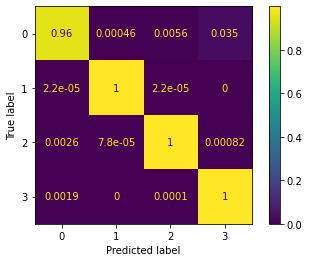

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(clf,X_train,y_train,normalize="true")

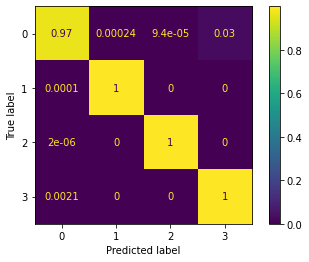

In [ ]:
plot_confusion_matrix(clf,X_cv,y_cv,normalize="true")

##Custom Stacking Classifier

#Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data,y,stratify=y,test_size=0.2,random_state=1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.50)

In [ ]:
X_train.shape

(1946968, 89)

In [ ]:
X_test.shape

(973485, 89)

In [12]:
import random

#Create a random sample with replacement
def get_sample(input_data,target_data):

  #60% of the data is generated randomly. Here, indices are selected randomly
  x_selected_row_indices = np.array(random.sample(range(0,input_data.shape[0]-1),1168180))

  #From the indices selected in the previous step, select data to include duplicates/repeats
  x_replacing_rows = np.array(random.choices(population = x_selected_row_indices,k= 778788))

  #Compute the data based on the indices
  sample_data = input_data.iloc[x_selected_row_indices]
  target_sample_data = target_data.take(x_selected_row_indices)

  replacing_data = input_data.iloc[x_replacing_rows]
  target_replacing_data = target_data.take(x_replacing_rows)

  #The sample with replacement is ready
  final_sample = np.vstack((sample_data,replacing_data))
  final_target = np.vstack((target_sample_data.values.reshape(-1,1),target_replacing_data.values.reshape(-1,1)))

  return final_sample,final_target

In [13]:
#Define the base classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

#create and return the Logistic classifier
def get_LR_model():
  model_lr = make_pipeline(StandardScaler(),SGDClassifier(loss='log',penalty='l2',class_weight='balanced',eta0=0.01,n_jobs=-1))
  return model_lr

#create and return the Decision Tree classifer
def get_DTClassifier_model():
  #standardize the data
  model_dtc = DecisionTreeClassifier(class_weight='balanced')
  return model_dtc

#create and return the Random Forest classifier
def get_RandomForest_model():
  model_rf= RandomForestClassifier()
  return model_rf

#create and return the XGBoost classifier
def get_xgBoost():
  model_xg = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss', max_delta_step=5, tree_method='hist', n_estimators=106, max_depth=11, learning_rate=0.38, n_jobs=-1)

  return model_xg


#Create all the base classifiers into a dictionary
def get_models_init():
  models_dict= {}
  models_dict['dec_tree'] = get_DTClassifier_model()
  models_dict['random_forest'] = get_RandomForest_model()
  models_dict['xg_boost'] = get_xgBoost()
  models_dict['lr'] = get_LR_model()

  return models_dict

models_trained = {}


In [14]:
#Retrieve the base models
trained_models=get_models_init()

#Create a dictionary which maps base classifiers' keys to names
model_names_dict={'dec_tree':'Decision Tree','random_forest':'Random Forest','xg_boost':'XGBoost','lr':'Logistic Regression'}

In [15]:

#Retrieve the sample of X_train and train using each base model iteratively. The trained model is returned to the dictionary.
def get_sample_and_train():

  #get sample
  sample_data, sample_y = get_sample(X_train,y_train)

  for idx,key in enumerate(trained_models):

    print('*'*100)
    print('Training Model -- ',model_names_dict[key])
    print('Training Started........')
    
    clf = trained_models[key]    
    clf.fit(sample_data, sample_y)

    print('Training Ended........')

    trained_models[key]= clf
    print(trained_models[key])
    print('*'*100)


#Initiate the sample and training process and define the number of times samples are taken and processed. 
#The trained models are saved after each sample
def sample_and_process():

  for i in range(0,2):

    print('*'*100)
    print('Sample No.', i+1)
    print('*'*100)
 
    get_sample_and_train()
    fstr = 'trained_models'+ str(i) + '.npy' 
    np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/'+fstr,trained_models) 

    print('*'*100)

   

In [ ]:
sample_and_process()

In [ ]:
#Save the trained models 
import joblib

for idx,key in enumerate(trained_models):

  fileName = key
  joblib.dump(trained_models[key], '/content/drive/MyDrive/Colab Notebooks/Aviation/'+key+'.pkl')

In [17]:
from sklearn.externals import joblib

#Retrieve the saved trained models

model_names_dict={'dec_tree':'Decision Tree','random_forest':'Random Forest','xg_boost':'XGBoost','lr':'Logistic Regression'}
trained_models={}
trained_models['dec_tree'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/dec_tree.pkl')
trained_models['random_forest'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/random_forest.pkl')
trained_models['xg_boost'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/xg_boost.pkl')
trained_models['lr'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/lr.pkl')



In [18]:
#Draw predictions on the dataset2-X_cv using the base classifiers

print('Predicting for Decision tree')
dec_tree_clf = trained_models['dec_tree']
dec_tree_predictions = dec_tree_clf.predict_proba(X_cv)
print('*'*100)
print('Predicting for Random Forest')

rf_clf = trained_models['random_forest']
rf_predictions = rf_clf.predict_proba(X_cv)


Predicting for Decision tree
****************************************************************************************************
Predicting for Random Forest


In [19]:
print('*'*100)
print('Predicting for XG Boost')
X_cv_xgboost = X_cv.values
xg_clf = trained_models['xg_boost']
xg_predictions = xg_clf.predict_proba(X_cv_xgboost)


****************************************************************************************************
Predicting for XG Boost


In [20]:
print('*'*100)
print('Predicting for Logistic Classification')
lr_clf = trained_models['lr']
lr_predictions = lr_clf.predict_proba(X_cv)

****************************************************************************************************
Predicting for Logistic Classification


In [21]:
print('Decision Tree Predictions',len(dec_tree_predictions))
print('Random Forest Predictions',len(rf_predictions))
print('XGBoost Predictions',len(xg_predictions))
print('Logistic Classification Predictions',len(lr_predictions))

Decision Tree Predictions 1946968
Random Forest Predictions 1946968
XGBoost Predictions 1946968
Logistic Classification Predictions 1946968


In [ ]:
print(len(y_cv))

1946968


In [ ]:
len(dec_tree_predictions[:,0])

1946968

In [22]:
#Create a dataframe of the predictions from the base model

dFinal = pd.DataFrame()
dFinal['d_predict_feature_0']  = dec_tree_predictions[:,0]
dFinal['d_predict_feature_1']  = dec_tree_predictions[:,1]
dFinal['d_predict_feature_2']  = dec_tree_predictions[:,2]
dFinal['d_predict_feature_3']  = dec_tree_predictions[:,3]

dFinal['rf_predict_feature_0']  = rf_predictions[:,0]
dFinal['rf_predict_feature_1']  = rf_predictions[:,1]
dFinal['rf_predict_feature_2']  = rf_predictions[:,2]
dFinal['rf_predict_feature_3']  = rf_predictions[:,3]

dFinal['xg_predict_feature_0']  = xg_predictions[:,0]
dFinal['xg_predict_feature_1']  = xg_predictions[:,1]
dFinal['xg_predict_feature_2']  = xg_predictions[:,2]
dFinal['xg_predict_feature_3']  = xg_predictions[:,3]

dFinal['lr_predict_feature_0']  = lr_predictions[:,0]
dFinal['lr_predict_feature_1']  = lr_predictions[:,1]
dFinal['lr_predict_feature_2']  = lr_predictions[:,2]
dFinal['lr_predict_feature_3']  = lr_predictions[:,3]
dFinal.columns

Index(['d_predict_feature_0', 'd_predict_feature_1', 'd_predict_feature_2',
       'd_predict_feature_3', 'rf_predict_feature_0', 'rf_predict_feature_1',
       'rf_predict_feature_2', 'rf_predict_feature_3', 'xg_predict_feature_0',
       'xg_predict_feature_1', 'xg_predict_feature_2', 'xg_predict_feature_3',
       'lr_predict_feature_0', 'lr_predict_feature_1', 'lr_predict_feature_2',
       'lr_predict_feature_3'],
      dtype='object')

In [23]:
dFinal.head()

,d_predict_feature_0,d_predict_feature_1,d_predict_feature_2,d_predict_feature_3,rf_predict_feature_0,rf_predict_feature_1,rf_predict_feature_2,rf_predict_feature_3,xg_predict_feature_0,xg_predict_feature_1,xg_predict_feature_2,xg_predict_feature_3,lr_predict_feature_0,lr_predict_feature_1,lr_predict_feature_2,lr_predict_feature_3
0,1.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.999998,1.968054e-08,1.964013e-06,4.283212e-07,0.386819,0.052109,0.263254,0.297819
1,1.0,0.0,0.0,0.0,0.99,0.0,0.01,0.0,0.999999,7.911747e-08,2.699844e-07,5.721300e-07,0.240124,0.434825,0.240524,0.084526
2,1.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.999976,1.693635e-06,9.475833e-06,1.272326e-05,0.453235,0.058116,0.368846,0.119803
3,1.0,0.0,0.0,0.0,0.98,0.0,0.02,0.0,0.999999,5.177982e-09,4.642100e-08,6.171718e-07,0.428860,0.005958,0.260860,0.304322
4,1.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,1.000000,2.452231e-09,9.376049e-08,3.988628e-07,0.432563,0.024595,0.362793,0.180049


In [24]:
y_final= y_cv.values
  

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Define param grid
param_grid = {'C': [0.1, 1, 10], 
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True,cv=3, verbose = 3)
grid.fit(dFinal,y_final)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.1, kernel=rbf, score=1.000, total= 1.2min
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................... C=0.1, kernel=rbf, score=1.000, total= 1.3min
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ................... C=0.1, kernel=rbf, score=1.000, total= 1.3min
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=1.000, total=  56.6s
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=1.000, total= 1.0min
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=1.000, total=  59.7s
[CV] C=10, kernel=rbf ................................................
[CV] .................... C=10, kernel=rbf, score=1.000, total= 1.3min
[CV] C=10, kernel=rbf ................................................
[CV] ................... C=10, kernel=rbf, score=1.000, total=152.3min
[CV] C=10, kernel=rbf ................................................


In [25]:
dFinal.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/Data_Final_Train.csv')

In [28]:
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/y_final.npy',y_final)

In [29]:
#Draw predictions on the dataset2-X_cv using the base classifiers


print('Predicting for Decision tree- Test Data')
dec_tree_clf = trained_models['dec_tree']
dec_tree_predictions_test = dec_tree_clf.predict_proba(X_test)
print('*'*100)
print('Predicting for Random Forest- Test Data')

rf_clf = trained_models['random_forest']
rf_predictions_test = rf_clf.predict_proba(X_test)


Predicting for Decision tree- Test Data
****************************************************************************************************
Predicting for Random Forest- Test Data


In [30]:
print('*'*100)
print('Predicting for XG Boost- Test Data')
X_test_xgboost = X_test.values
xg_clf = trained_models['xg_boost']
xg_predictions_test = xg_clf.predict_proba(X_test_xgboost)


****************************************************************************************************
Predicting for XG Boost- Test Data


In [31]:
print('*'*100)
print('Predicting for Logistic Classification - Test Data')
lr_clf = trained_models['lr']
lr_predictions_test = lr_clf.predict_proba(X_test)

****************************************************************************************************
Predicting for Logistic Classification - Test Data


In [32]:
#Create a dataframe of the predictions from the test data

dTest = pd.DataFrame()
dTest['d_predict_feature_0']  = dec_tree_predictions_test[:,0]
dTest['d_predict_feature_1']  = dec_tree_predictions_test[:,1]
dTest['d_predict_feature_2']  = dec_tree_predictions_test[:,2]
dTest['d_predict_feature_3']  = dec_tree_predictions_test[:,3]

dTest['rf_predict_feature_0']  = rf_predictions_test[:,0]
dTest['rf_predict_feature_1']  = rf_predictions_test[:,1]
dTest['rf_predict_feature_2']  = rf_predictions_test[:,2]
dTest['rf_predict_feature_3']  = rf_predictions_test[:,3]

dTest['xg_predict_feature_0']  = xg_predictions_test[:,0]
dTest['xg_predict_feature_1']  = xg_predictions_test[:,1]
dTest['xg_predict_feature_2']  = xg_predictions_test[:,2]
dTest['xg_predict_feature_3']  = xg_predictions_test[:,3]

dTest['lr_predict_feature_0']  = lr_predictions_test[:,0]
dTest['lr_predict_feature_1']  = lr_predictions_test[:,1]
dTest['lr_predict_feature_2']  = lr_predictions_test[:,2]
dTest['lr_predict_feature_3']  = lr_predictions_test[:,3]
dTest.columns

Index(['d_predict_feature_0', 'd_predict_feature_1', 'd_predict_feature_2',
       'd_predict_feature_3', 'rf_predict_feature_0', 'rf_predict_feature_1',
       'rf_predict_feature_2', 'rf_predict_feature_3', 'xg_predict_feature_0',
       'xg_predict_feature_1', 'xg_predict_feature_2', 'xg_predict_feature_3',
       'lr_predict_feature_0', 'lr_predict_feature_1', 'lr_predict_feature_2',
       'lr_predict_feature_3'],
      dtype='object')

In [33]:
dTest.head()

,d_predict_feature_0,d_predict_feature_1,d_predict_feature_2,d_predict_feature_3,rf_predict_feature_0,rf_predict_feature_1,rf_predict_feature_2,rf_predict_feature_3,xg_predict_feature_0,xg_predict_feature_1,xg_predict_feature_2,xg_predict_feature_3,lr_predict_feature_0,lr_predict_feature_1,lr_predict_feature_2,lr_predict_feature_3
0,1.0,0.0,0.0,0.0,0.99,0.0,0.00,0.01,0.999991,3.201625e-07,1.575018e-06,7.383851e-06,0.409061,0.025684,0.289098,0.276158
1,1.0,0.0,0.0,0.0,0.91,0.0,0.06,0.03,0.999999,1.338195e-08,4.413938e-07,4.750798e-07,0.440573,0.090711,0.288531,0.180185
2,1.0,0.0,0.0,0.0,0.99,0.0,0.01,0.00,0.999991,1.711884e-06,7.182559e-06,5.539699e-07,0.250845,0.478236,0.180949,0.089970
3,1.0,0.0,0.0,0.0,0.93,0.0,0.06,0.01,0.999999,9.837978e-08,1.927741e-07,2.953256e-07,0.499351,0.000994,0.351995,0.147660
4,1.0,0.0,0.0,0.0,0.97,0.0,0.03,0.00,1.000000,8.829694e-09,3.062718e-07,2.583985e-08,0.411931,0.026515,0.332417,0.229137


In [34]:
from sklearn.linear_model import LogisticRegression

#Define the meta-classifier. 
meta_clf = LogisticRegression()
#The metaclassifier is fit to the data predictions of the training data
meta_clf.fit(dFinal, y_final)

#The metaclassifier predicts from the test data
results = meta_clf.predict_proba(dTest)

In [35]:
joblib.dump(meta_clf, '/content/drive/MyDrive/Colab Notebooks/Aviation/meta_clf.pkl')

['/content/drive/MyDrive/Colab Notebooks/Aviation/meta_clf.pkl']

In [36]:
results_train = meta_clf.predict_proba(dFinal)

In [ ]:
results.shape

(973485, 4)

In [ ]:
y_test.shape

(973485,)

In [37]:
from sklearn.metrics import log_loss

print("Log loss on Training Data using Stacking Classifier = ",log_loss(y_final,results_train))
print("Log loss on Test Data using Stacking Classifier = ",log_loss(y_test,results))


Log loss on Training Data using Stacking Classifier =  0.0006721678553199909
Log loss on Test Data using Stacking Classifier =  0.001003768864120054


In [38]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ['Model', "Log Loss - CV/Test","Log Loss - Train"]

x.add_row(["Random", 1.6453862113031215,1.6453149258986033])
x.add_row(["Logistic", 1.397306330411393,1.3971090540821176])
x.add_row(["LGBM", 0.08986266102611351,0.08901636748760548])
x.add_row(["Stacking Classifier", 0.001003768864120054,0.0006721678553199909])

print(x)

+---------------------+----------------------+-----------------------+
|        Model        |  Log Loss - CV/Test  |    Log Loss - Train   |
+---------------------+----------------------+-----------------------+
|        Random       |  1.6453862113031215  |   1.6453149258986033  |
|       Logistic      |  1.397306330411393   |   1.3971090540821176  |
|         LGBM        | 0.08986266102611351  |  0.08901636748760548  |
| Stacking Classifier | 0.001003768864120054 | 0.0006721678553199909 |
+---------------------+----------------------+-----------------------+


Summary

4 different classifiers/models were run on the given data. Amongst all, the Stacking classifier had the lowest log loss. LGBM model gives the next lowest  log loss. The log loss metric achieved by both these models are very good.

The Random and the Logistic models gave an unfavourable log loss and are highly unrecommended.